<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/008_TensorFlow_Proj_Eight_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libs

In [1]:
# utils
import warnings, os, sys, warnings
import pandas as pd
import numpy as np
# colab
from google.colab import drive
# tensorflow
import tensorflow as tf
from tensorflow.config import list_physical_devices, experimental
# sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# vis
import matplotlib.pyplot as plt

In [2]:
print("tensorflow:", tf.__version__)

tensorflow: 2.17.0


### Setup

In [3]:
warnings.filterwarnings("ignore")

In [4]:
physical_devices = list_physical_devices("GPU")
experimental.set_memory_growth(physical_devices[0], True)

### Dataset

In [5]:
url = "https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv"
stocks = pd.read_csv(url, index_col=0, header=[0,1])
stocks.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.722874  125.150002  80.229012  152.072800  243.072266   
2018-01-03  40.715786  124.820000  80.602394  153.550400  244.609711   
2018-01-04  40.904907  125.459999  81.311806  153.819046  245.640732   
2018-01-05  41.370617  125.330002  82.319908  155.363861  247.277679   
2018-01-08  41.216949  125.309998  82.403923  155.968399  247.729935   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

### Univariate Forcasting Prices

In [6]:
stocks.index = pd.to_datetime(stocks.index).to_period('B')
stocks.index

PeriodIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
             '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
             '2018-01-12', '2018-01-16',
             ...
             '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
             '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
             '2023-12-28', '2023-12-29'],
            dtype='period[B]', name='Date', length=1509)

In [7]:
_df = stocks["Close"][["AAPL"]]
_df.head()

,AAPL
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502


In [8]:
assert _df.index.is_monotonic_increasing

In [9]:
idx = pd.period_range(min(_df.index), max(_df.index))
df = _df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')
df.tail(5)

,AAPL
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994
2023-12-28,193.580002
2023-12-29,192.529999


<Axes: >

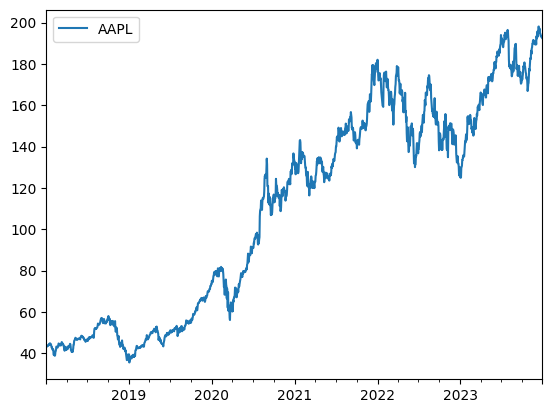

In [10]:
df.plot()

In [11]:
df['Log_AAPL']= np.log(df['AAPL'])
df = df[304:]
df.head()

,AAPL,Log_AAPL
2019-03-04,43.962502,3.783337
2019-03-05,43.882500,3.781516
2019-03-06,43.630001,3.775745
2019-03-07,43.125000,3.764103
2019-03-08,43.227501,3.766477


<Axes: >

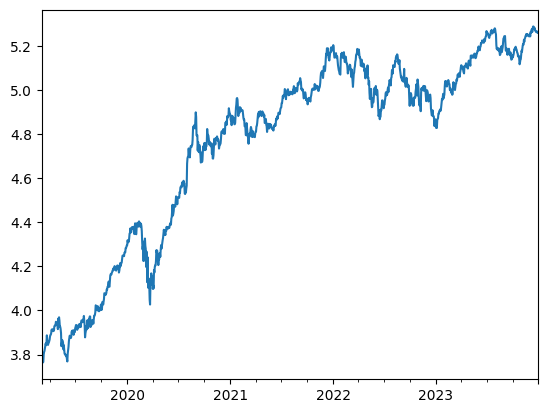

In [12]:
df["Log_AAPL"].plot()

In [13]:
test_period = 100
train_period = len(df) - test_period
train_set = df.iloc[:train_period]
test_set  = df.iloc[train_period:]
train_indicator = (df.index <= train_set.index[-1])
test_indicator =  (df.index > train_set.index[-1])
log_aapl = df['Log_AAPL'].dropna().to_numpy()
delta_x, delta_y = 100, 1
X = np.array(
    [log_aapl[t:t+delta_x] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_x, 1)
Y = np.array(
    [log_aapl[t+delta_x+delta_y-1] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_y)
print("X:", X.shape, "Y:", Y.shape)
X_train, y_train = X[:-test_period], Y[:-test_period]
X_test, y_test = X[-test_period:], Y[-test_period:]

X: (1160, 100, 1) Y: (1160, 1)


In [14]:
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
features = tf.keras.layers.LSTM(units=16)(inputs)
outputs = tf.keras.layers.Dense(1)(features)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(X_train, y_train, epochs=10, validation_split=0.3)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 17.7105 - mae: 4.1605 - val_loss: 11.9800 - val_mae: 3.4594
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4699 - mae: 2.8803 - val_loss: 7.4977 - val_mae: 2.7358
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9211 - mae: 2.1814 - val_loss: 4.1224 - val_mae: 2.0272
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3026 - mae: 1.4642 - val_loss: 1.9100 - val_mae: 1.3774
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8768 - mae: 0.8479 - val_loss: 0.5605 - val_mae: 0.7400
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2036 - mae: 0.3995 - val_loss: 0.1064 - val_mae: 0.3095
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0404 - mae: 0.1723 - val_loss: 0.0163 - val_mae: 0.1038
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mae: 0.0825 - val_loss: 0.0082 - val_mae: 0.0728
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - ma

In [15]:
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [16]:
train_indicator[:delta_x] = False
df.loc[train_indicator, 'one_step_train'] =  train_predictions
df.loc[test_indicator, 'one_step_test'] =  test_predictions

<Axes: >

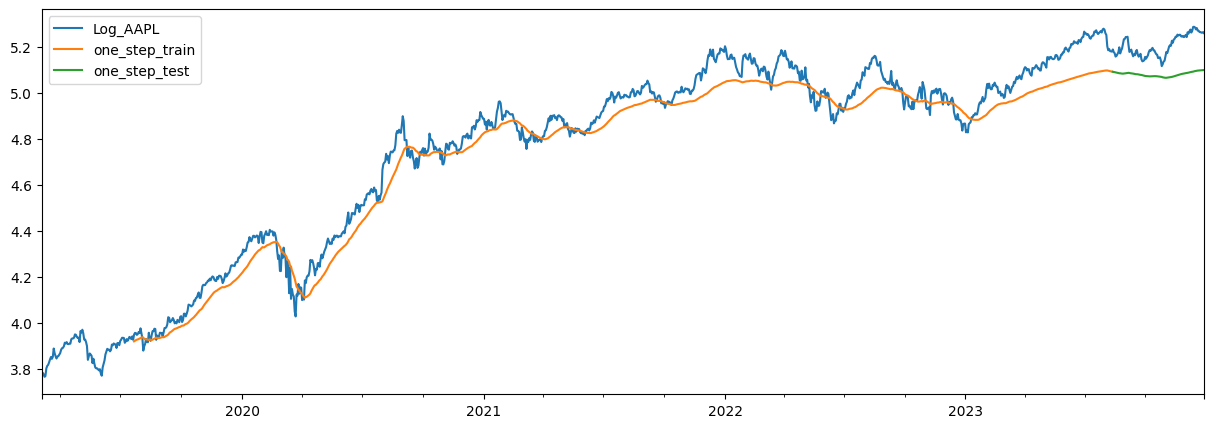

In [17]:
df[['Log_AAPL', 'one_step_train', 'one_step_test']].plot(figsize=(15, 5))

In [18]:
multistep_predictions = []
X_final = X_test[0]
while len(multistep_predictions) < test_period:
  pred = model.predict(X_final.reshape(1, -1, 1))[0]
  multistep_predictions.append(pred)
  X_final = np.roll(X_final, -1)
  X_final[-1] = pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [19]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions

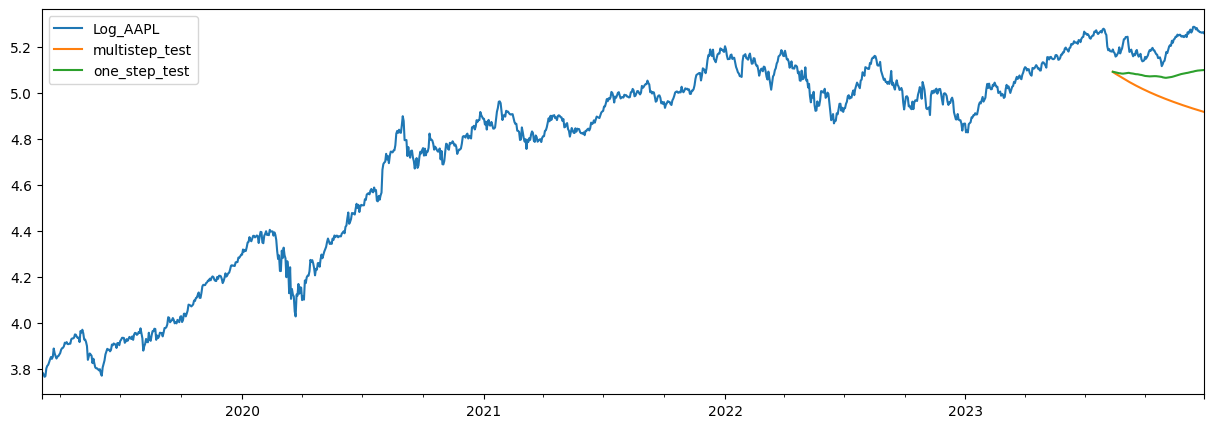

In [20]:
df[['Log_AAPL', 'multistep_test', 'one_step_test']].plot(figsize=(15, 5))

In [21]:
delta_x, delta_y = 100, 100
X = np.array(
    [log_aapl[t:t+delta_x] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_x, 1)
Y = np.array(
    [log_aapl[t+delta_x:t+delta_x+delta_y] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_y)
print("X:", X.shape, "Y:", Y.shape)
X_train_multi_out, y_train_multi_out = X[:-1], Y[:-1]
X_test_multi_out, y_test_multi_out = X[-1:], Y[-1:]

X: (1061, 100, 1) Y: (1061, 100)


In [22]:
tf.keras.backend.clear_session()
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features), name="input_layer")
feat = tf.keras.layers.LSTM(16 , return_sequences=False, name="lstm_layer")(inputs)
outputs = tf.keras.layers.Dense(delta_y, name="dense_layer")(feat)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(X_train_multi_out, y_train_multi_out, epochs=10, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 100)                 │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,852 (11.14 KB)

 Trainable params: 2,852 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 22.5301 - mae: 4.7304 - val_loss: 23.8607 - val_mae: 4.8773
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.9568 - mae: 4.4469 - val_loss: 20.2997 - val_mae: 4.4932
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.4945 - mae: 4.0324 - val_loss: 16.0443 - val_mae: 3.9865
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.4808 - mae: 3.4947 - val_loss: 12.1000 - val_mae: 3.4521
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1908 - mae: 2.9826 - val_loss: 8.7628 - val_mae: 2.9256
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3869 - mae: 2.4640 - val_loss: 6.0982 - val_mae: 2.4259
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2459 - mae: 1.9819 - val_loss: 4.0315 - val_mae: 1.9540
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5282 - mae: 1.4886 - val_loss: 2.4786 - val_mae: 1.5084
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.43

<Axes: >

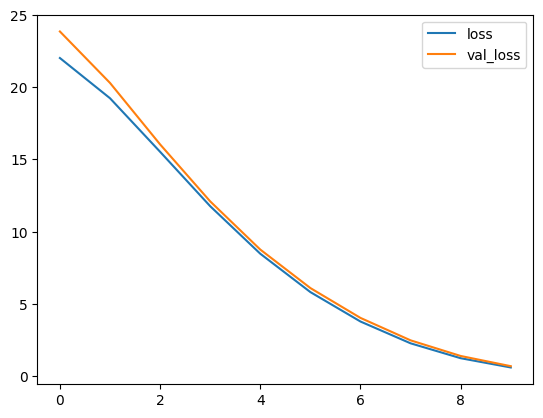

In [38]:
metrics = pd.DataFrame(monitor.history)
metrics[['loss', 'val_loss']].plot()

In [36]:
metrics

,loss,mae,val_loss,val_mae
0,22.023630,4.676504,23.860703,4.877309
1,19.239407,4.364320,20.299658,4.493233
2,15.531847,3.909493,16.044254,3.986514
3,11.766142,3.388856,12.100044,3.452127
4,8.474913,2.857262,8.762772,2.925615
5,5.818942,2.344810,6.098173,2.425870
6,3.781324,1.859177,4.031543,1.953992
7,2.273161,1.403841,2.478603,1.508383
8,1.242061,0.989602,1.396917,1.106898
9,0.601026,0.654549,0.689967,0.751978


In [24]:
train_pred = model.predict(X_train_multi_out)[:,0]
test_pred = model.predict(X_test_multi_out)[0]

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [25]:
df.loc[test_indicator, 'multioutput_test'] = test_pred

<Axes: >

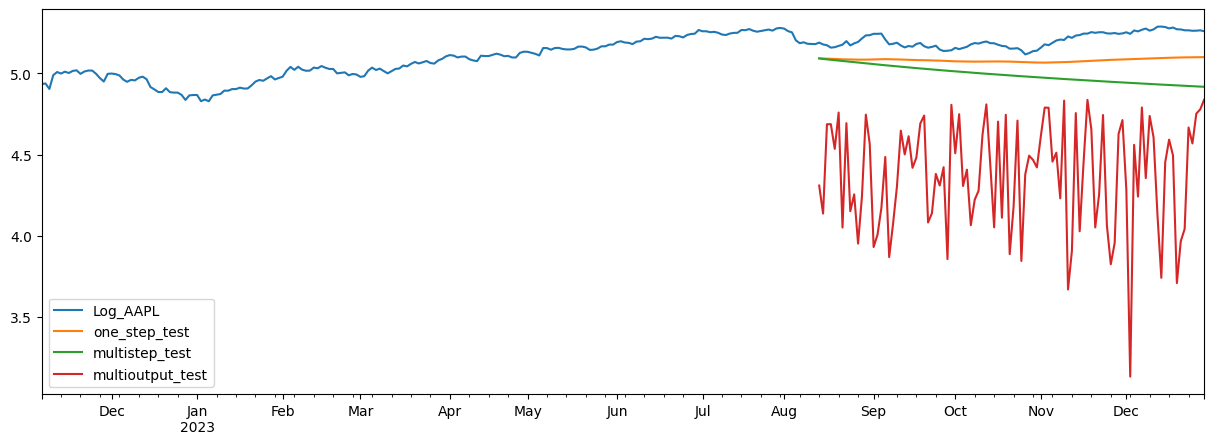

In [26]:
cols = ['Log_AAPL', 'one_step_test', 'multistep_test',  'multioutput_test']
df.iloc[-300:][cols].plot(figsize=(15, 5))

In [27]:
test_log_price = df.iloc[-test_period:]['Log_AAPL']
mae1 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mae2 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mae3 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step_test MAE:", mae1)
print("multi-step MAE:", mae2)
print("multi-output MAE:", mae3)

one-step_test MAE: 0.12404682603238275
multi-step MAE: 0.21308984246609852
multi-output MAE: 0.83358869281171


### Univariate Forcasting Returns

In [39]:
tf.keras.backend.clear_session()

In [40]:
idx = pd.period_range(min(_df.index), max(_df.index))
dataframe = _df.reindex(idx, fill_value=np.nan)
dataframe.fillna(method = 'ffill', inplace=True)
dataframe.tail(10)

,AAPL
2023-12-18,195.889999
2023-12-19,196.940002
2023-12-20,194.830002
2023-12-21,194.679993
2023-12-22,193.600006
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994
2023-12-28,193.580002
2023-12-29,192.529999


In [41]:
dataframe["Log_AAPL"] = np.log(dataframe["AAPL"])
dataframe["Diff_Log_AAPL"] = dataframe["Log_AAPL"].diff(1)

<Axes: >

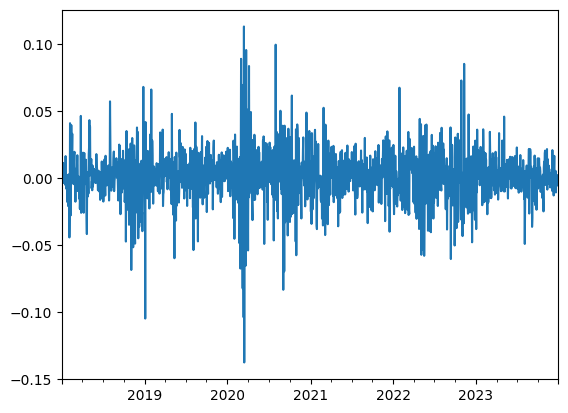

In [42]:
dataframe["Diff_Log_AAPL"].plot()

In [43]:
dataframe["Diff_Log_AAPL"].describe()

,Diff_Log_AAPL
count,1563.000000
mean,0.000958
std,0.019616
min,-0.137708
25%,-0.007957
50%,0.000487
75%,0.011234
max,0.113157


In [44]:
raw_frame = dataframe.copy()

In [45]:
num_train_samples = int(0.6 * len(dataframe))
num_val_samples = int(0.2 * len(dataframe))
num_test_samples = len(dataframe) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 938
num_val_samples: 312
num_test_samples: 314


In [46]:
series = dataframe['Diff_Log_AAPL'].dropna().to_numpy()
sequence_length = 60 # using the past 60 days to predict next day.
no_steps_ahead = 1
delay = sequence_length  + no_steps_ahead - 1
batch_size = 32
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [47]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

samples shape: (32, 60)
targets shape: (32,)


In [48]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [49]:
print("Validation MAE: {:.3f}".format(evaluate_naive_method(val_dataset)))
print("Test MAE: {:.3f}".format(evaluate_naive_method(test_dataset)))

Validation MAE: 0.022
Test MAE: 0.014


In [50]:
test_performance = {}

In [51]:
test_performance['Baseline'] = evaluate_naive_method(test_dataset)

In [52]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
features = tf.keras.layers.SimpleRNN(16, name="rnn_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="dense_layer")(features)
model = tf.keras.Model(inputs, outputs, name="simple_rnn_model")
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor= model.fit(train_dataset, epochs=10, validation_data=val_dataset)
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

Model: "simple_rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_layer (SimpleRNN)                │ (None, 16)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 8.5680e-04 - val_mae: 0.0229
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9737e-04 - mae: 0.0177 - val_loss: 6.2712e-04 - val_mae: 0.0195
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8315e-04 - mae: 0.0157 - val_loss: 5.3502e-04 - val_mae: 0.0179
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3684e-04 - mae: 0.0148 - val_loss: 5.0057e-04 - val_mae: 0.0172
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1570e-04 - mae: 0.0144 - val_loss: 4.8212e-04 - val_mae: 0.0168
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0390e-04 - mae: 0.0142 - val_loss: 4.7107e-04 - val_mae: 0.0166
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9673e-04 - mae: 0.0141 - val_loss: 4.6379e-04 - val_mae: 0.0165
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9197e-04 - mae: 0.0140 - val_loss: 4.5889e-04 - val_mae: 0.0164
Epoc

In [53]:
test_performance['SimpleRNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.01396827153391001, 'SimpleRNN': 0.009705066680908203}

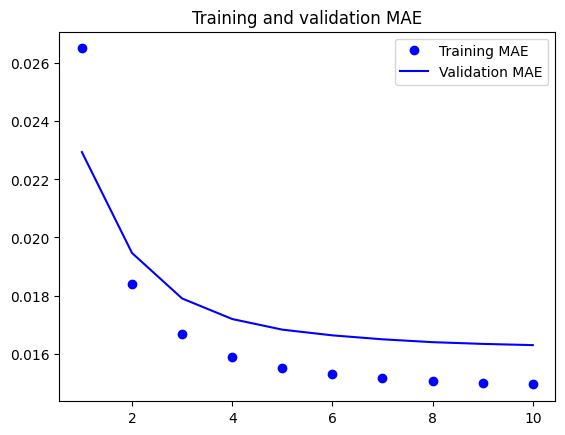

In [54]:
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [55]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
features = tf.keras.layers.LSTM(16, name="lstm_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="dense_layer")(features)
model = tf.keras.Model(inputs, outputs, name="lstm_model")
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor= model.fit(train_dataset, epochs=10, validation_data=val_dataset)
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1864e-04 - mae: 0.0145 - val_loss: 4.2000e-04 - val_mae: 0.0157
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8865e-04 - mae: 0.0134 - val_loss: 4.2000e-04 - val_mae: 0.0157
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8856e-04 - mae: 0.0134 - val_loss: 4.2002e-04 - val_mae: 0.0157
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8846e-04 - mae: 0.0134 - val_loss: 4.2003e-04 - val_mae: 0.0157
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8837e-04 - mae: 0.0134 - val_loss: 4.2005e-04 - val_mae: 0.0157
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.8827e-04 - mae: 0.0134 - val_loss: 4.2006e-04 - val_mae: 0.0157
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.8819e-04 - mae: 0.0134 - val_loss: 4.2008e-04 - val_mae: 0.0157
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.8810e-04 - mae: 0.0134 - val_loss: 4.2009e-04 - val_mae: 0.0157
E

In [56]:
test_performance['LSTM'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.01396827153391001,
 'SimpleRNN': 0.009705066680908203,
 'LSTM': 0.009764105081558228}

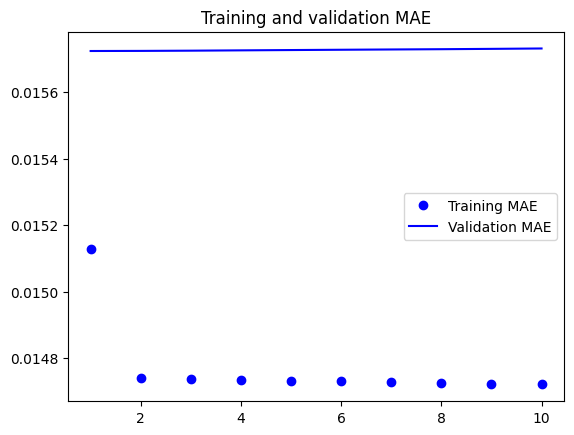

In [57]:
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0240 - mae: 0.0969 - val_loss: 4.6969e-04 - val_mae: 0.0173
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0012 - mae: 0.0263 - val_loss: 4.1945e-04 - val_mae: 0.0157
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 6.3750e-04 - mae: 0.0185 - val_loss: 4.3119e-04 - val_mae: 0.0161
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 6.0289e-04 - mae: 0.0176 - val_loss: 4.9368e-04 - val_mae: 0.0179
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 5.7493e-04 - mae: 0.0180 - val_loss: 4.4468e-04 - val_mae: 0.0166
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 5.1318e-04 - mae: 0.0170 - val_loss: 4.7454e-04 - val_mae: 0.0174
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 5.3212e-04 - mae: 0.0166 - val_loss: 4.4394e-04 - val_mae: 0.0166
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 5.2010e-04 - mae: 0.0168 - val_loss: 4.2483e-04 - val_mae: 0.016

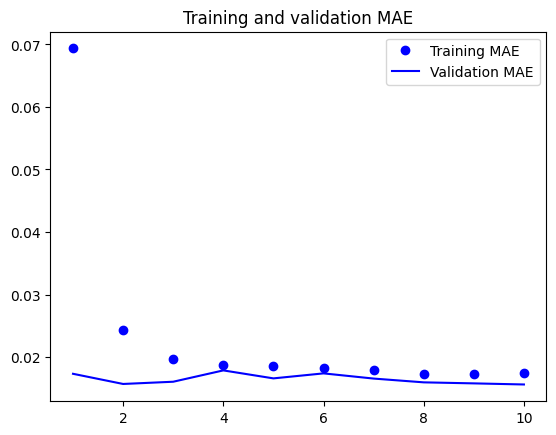

In [58]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
feat = tf.keras.layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True, name="lstm_layer")(inputs)
feat = tf.keras.layers.SimpleRNN(128, recurrent_dropout=0.1, name="rnn_layer")(feat)
feat = tf.keras.layers.Dropout(0.1, name="drop_out_layer")(feat)
outputs = tf.keras.layers.Dense(1, name="output_layer")(feat)
model = tf.keras.Model(inputs, outputs, name="lstm_with_recurrent_dropout")
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [59]:
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8227e-04 - mae: 0.0104
Test MAE: 0.00995


In [60]:
test_performance['Stacked_RNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.01396827153391001,
 'SimpleRNN': 0.009705066680908203,
 'LSTM': 0.009764105081558228,
 'Stacked_RNN': 0.009950008243322372}

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0061 - mae: 0.0478 - val_loss: 6.8997e-04 - val_mae: 0.0204
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.1753e-04 - mae: 0.0185 - val_loss: 6.8186e-04 - val_mae: 0.0213
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.0664e-04 - mae: 0.0186 - val_loss: 6.2977e-04 - val_mae: 0.0206
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.4957e-04 - mae: 0.0178 - val_loss: 4.8127e-04 - val_mae: 0.0173
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.0949e-04 - mae: 0.0170 - val_loss: 4.9343e-04 - val_mae: 0.0176
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7508e-04 - mae: 0.0162 - val_loss: 4.7991e-04 - val_mae: 0.0173
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5854e-04 - mae: 0.0159 - val_loss: 4.7066e-04 - val_mae: 0.0170
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4592e-04 - mae: 0.0156 - val_loss: 4.6385e-04 - val_mae: 0.0169
Epoc

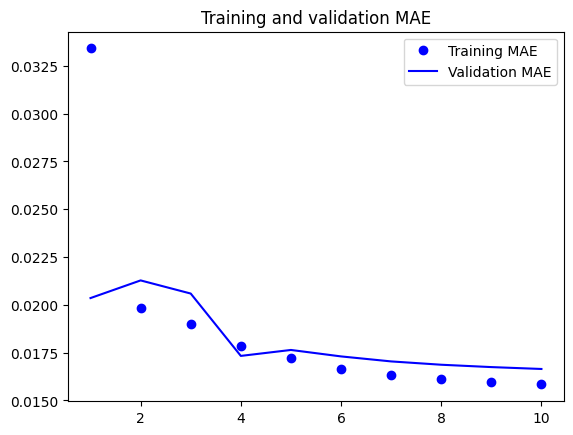

In [61]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
x = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32),
                                  name="bidirectional_rnn_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="output_layer")(x)
model = tf.keras.Model(inputs, outputs, name="bidirectional_rnn_model")
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [62]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.5f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.2802e-04 - mae: 0.0115
Test MAE: 0.01109


In [63]:
test_performance['Bidirectional_RNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.01396827153391001,
 'SimpleRNN': 0.009705066680908203,
 'LSTM': 0.009764105081558228,
 'Stacked_RNN': 0.009950008243322372,
 'Bidirectional_RNN': 0.011091913096606731}

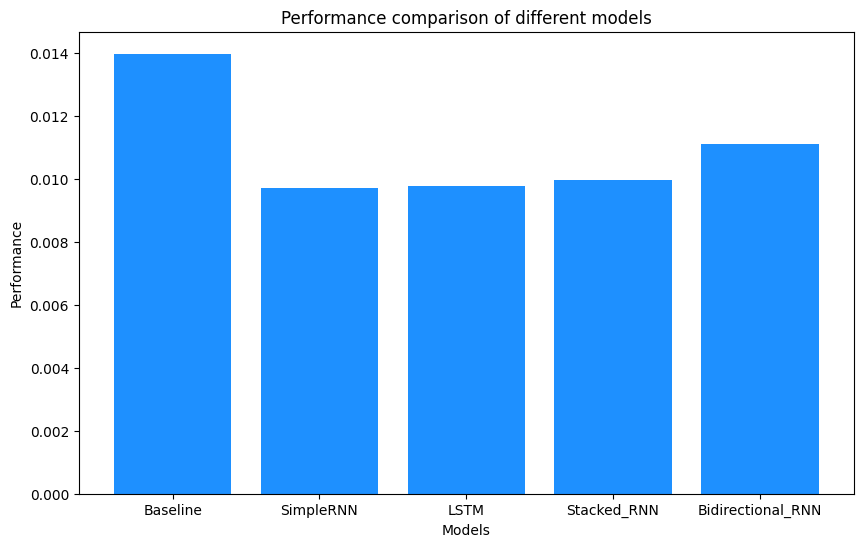

In [64]:
models = list(test_performance.keys())
values = list(test_performance.values())
plt.figure(figsize=(10, 6))
plt.bar(models, values, color='dodgerblue')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance comparison of different models')
plt.show()

In [65]:
df = raw_frame.copy()
df = df[304:]
df.head()

,AAPL,Log_AAPL,Diff_Log_AAPL
2019-03-04,43.962502,3.783337,0.005017
2019-03-05,43.882500,3.781516,-0.001821
2019-03-06,43.630001,3.775745,-0.005771
2019-03-07,43.125000,3.764103,-0.011642
2019-03-08,43.227501,3.766477,0.002374


In [66]:
test_period = 100
train_period = len(df) - test_period
print("train_period:", train_period)
print("test_period:", test_period)

train_period: 1160
test_period: 100


In [67]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

In [68]:
series = df['Diff_Log_AAPL'].dropna().to_numpy()
delta_x = 100 # using the past 100 observations to forecast the next one.
delta_y = 1 # forecasting only one step ahead
X = np.array([series[t:t+delta_x] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_x, 1)
Y = np.array([series[t+delta_x+delta_y-1] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_y)
N = len(X)
print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (1160, 100, 1) Y: (1160, 1) N: 1160


In [69]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [70]:
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain, epochs=10, validation_data=(Xtest,Ytest))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.9068e-04 - mae: 0.0157 - val_loss: 4.2168e-04 - val_mae: 0.0182
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6613e-04 - mae: 0.0156 - val_loss: 1.4257e-04 - val_mae: 0.0091
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3184e-04 - mae: 0.0149 - val_loss: 2.4289e-04 - val_mae: 0.0123
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4626e-04 - mae: 0.0153 - val_loss: 2.4124e-04 - val_mae: 0.0131
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7084e-04 - mae: 0.0154 - val_loss: 1.3670e-04 - val_mae: 0.0091
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7058e-04 - mae: 0.0153 - val_loss: 1.5127e-04 - val_mae: 0.0093
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0627e-04 - mae: 0.0143 - val_loss: 1.3820e-04 - val_mae: 0.0090
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2765e-04 - mae: 0.0148 - val_loss: 1.4382e-04 - val_mae: 0.0095
Epoch 9

In [71]:
train_predictions = model.predict(Xtrain).flatten()
test_predictions = model.predict(Xtest).flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [72]:
df['Lag_Log_AAPL'] = df['Log_AAPL'].shift(1)
lag = df['Lag_Log_AAPL']

In [73]:
train_indicator[:delta_x] = False

In [74]:
df.loc[train_indicator, 'one_step_train'] = lag[train_indicator] + train_predictions
df.loc[test_indicator, 'one_step_test'] = lag[test_indicator] + test_predictions

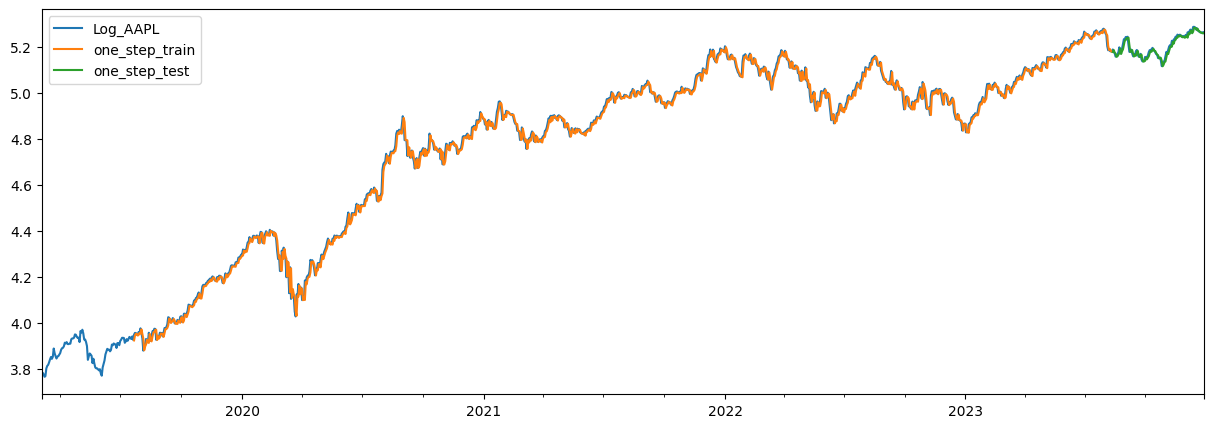

In [75]:
df[['Log_AAPL', 'one_step_train', 'one_step_test']].plot(figsize=(15, 5));

In [76]:
multistep_predictions = []
last_x = Xtest[0]
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  multistep_predictions.append(prediction)
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [77]:
last_train = train.iloc[-1]['Log_AAPL']

In [78]:
df.loc[test_indicator, 'multistep_test'] = last_train + np.cumsum(multistep_predictions)

<Axes: >

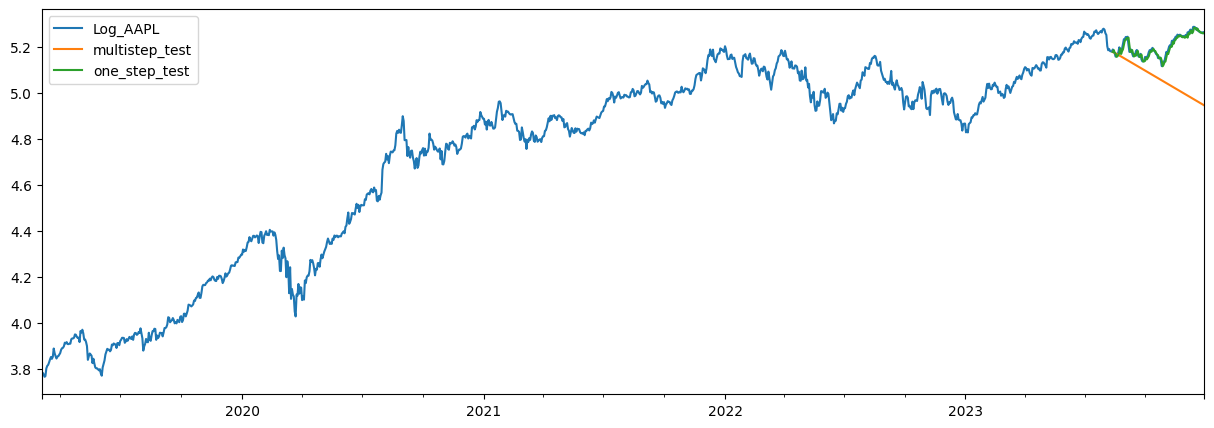

In [79]:
df[['Log_AAPL', 'multistep_test', 'one_step_test']].plot(figsize=(15, 5))

In [80]:
delta_x = 100
delta_y = test_period
X = np.array([series[t:t+delta_x] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_x, 1)
Y = np.array([series[t+delta_x:t+delta_x+delta_y] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_y)
N = len(X)
print("X:", X.shape, "Y:", Y.shape, "N:", N)
Xtrain_multi_out, Ytrain_multi_out = X[:-1], Y[:-1]
Xtest_multi_out, Ytest_multi_out = X[-1:], Y[-1:]
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
x = tf.keras.layers.LSTM(16, return_sequences=True)(inputs)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(delta_y)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain_multi_out, Ytrain_multi_out,
                    epochs=10,
                    validation_data=(Xtest_multi_out,Ytest_multi_out)
                    )
train_predictions = model.predict(Xtrain_multi_out)
test_predictions = model.predict(Xtest_multi_out)
train_predictions = train_predictions[:,0]
test_predictions = test_predictions[0]
df.loc[test_indicator, 'multioutput_test'] = last_train + np.cumsum(test_predictions)

X: (1061, 100, 1) Y: (1061, 100) N: 1061


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 16)             │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,852 (11.14 KB)

 Trainable params: 2,852 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3399e-04 - mae: 0.0145 - val_loss: 1.3638e-04 - val_mae: 0.0090
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3078e-04 - mae: 0.0145 - val_loss: 1.3122e-04 - val_mae: 0.0089
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3554e-04 - mae: 0.0145 - val_loss: 1.3550e-04 - val_mae: 0.0090
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2882e-04 - mae: 0.0144 - val_loss: 1.3332e-04 - val_mae: 0.0090
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1899e-04 - mae: 0.0143 - val_loss: 1.3466e-04 - val_mae: 0.0090
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4038e-04 - mae: 0.0146 - val_loss: 1.3503e-04 - val_mae: 0.0090
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3566e-04 - mae: 0.0145 - val_loss: 1.3389e-04 - val_mae: 0.0090
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2762e-04 - mae: 0.0144 - val_loss: 1.3644e-04 - val_mae: 0.0090
Epoch 9

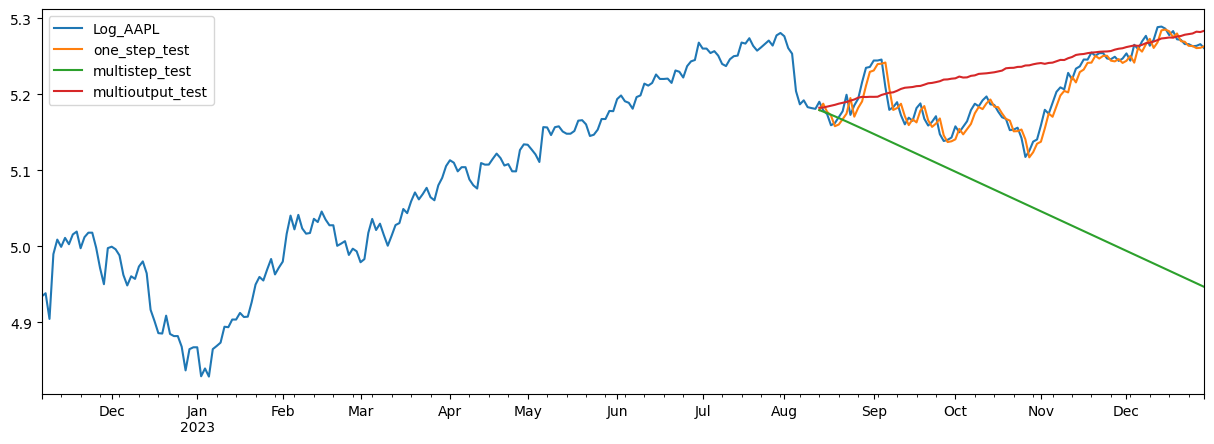

In [81]:
cols = ['Log_AAPL', 'one_step_test', 'multistep_test',  'multioutput_test']
df.iloc[-300:][cols].plot(figsize=(15, 5));

In [82]:
test_log_price = df.iloc[-test_period:]['Log_AAPL']
mae1 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mae2 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mae3 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step MAE:", mae1)
print("multi-step MAE:", mae2)
print("multi-output MAE:", mae3)

one-step MAE: 0.009845646983640854
multi-step MAE: 0.14303767464143216
multi-output MAE: 0.03411034191644763


In [83]:
mape1 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mape2 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mape3 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step MAE:", mape1)
print("multi-step MAE:", mape2)
print("multi-output MAE:", mape3)

one-step MAE: 0.0018934417599359337
multi-step MAE: 0.027322716818266177
multi-output MAE: 0.006589470881838465


### Univariate Forcasting Plots Using TensorFlow

In [84]:
df_aapl = df[["AAPL"]]

In [85]:
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1260 entries, 2019-03-04 to 2023-12-29
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1260 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [86]:
column_indices = {name: i for i, name in enumerate(df_aapl.columns)}
n = len(df_aapl)
train_df = df_aapl[0:int(n*0.7)]
val_df = df_aapl[int(n*0.7):int(n*0.9)]
test_df = df_aapl[int(n*0.9):]
num_features = df_aapl.shape[1]

In [87]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [88]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    # store the raw data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # work out the label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # work out the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [89]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['AAPL'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['AAPL']

In [90]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # slicing doesn't preserve static shape information, so set the shapes manually
  # this way the `tf.data.Datasets` are easier to inspect
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [91]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [92]:
example_window

<tf.Tensor: shape=(3, 7, 1), dtype=float64, numpy=
array([[[-1.55746297],
        [-1.5593818 ],
        [-1.56543796],
        [-1.57755037],
        [-1.5750919 ],
        [-1.53917454],
        [-1.52712206]],

       [[-1.36936125],
        [-1.35964739],
        [-1.36066674],
        [-1.37056048],
        [-1.36624319],
        [-1.35461058],
        [-1.36000715]],

       [[-1.01138624],
        [-1.00203213],
        [-0.9883009 ],
        [-0.98416349],
        [-0.96203738],
        [-0.93379519],
        [-0.93049715]]])>

In [93]:
example_inputs

<tf.Tensor: shape=(3, 6, 1), dtype=float64, numpy=
array([[[-1.55746297],
        [-1.5593818 ],
        [-1.56543796],
        [-1.57755037],
        [-1.5750919 ],
        [-1.53917454]],

       [[-1.36936125],
        [-1.35964739],
        [-1.36066674],
        [-1.37056048],
        [-1.36624319],
        [-1.35461058]],

       [[-1.01138624],
        [-1.00203213],
        [-0.9883009 ],
        [-0.98416349],
        [-0.96203738],
        [-0.93379519]]])>

In [94]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.52712206]],

       [[-1.36000715]],

       [[-0.93049715]]])>

In [95]:
w1.example = example_inputs, example_labels

In [96]:
def plot(self, model=None, plot_col='AAPL', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

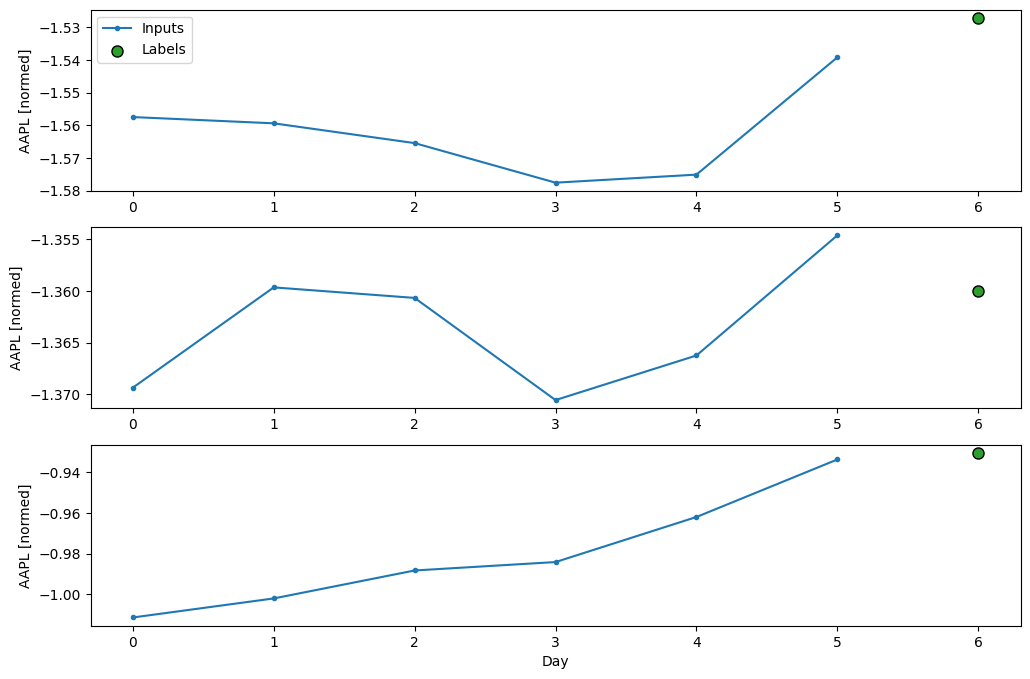

In [97]:
w1.plot()

In [98]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [99]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # no example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # and cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [100]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [101]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [102]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AAPL'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AAPL']

In [103]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [104]:
column_indices

{'AAPL': 0}

In [105]:
baseline = Baseline(label_index=column_indices['AAPL']) # we are selecting the 'AAPL' feature for making the baseline prediction

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0041 - mean_absolute_error: 0.0461


In [106]:
val_performance

{'Baseline': [0.004312998149544001, 0.047871410846710205]}

In [107]:
performance

{'Baseline': [0.002681300975382328, 0.039202895015478134]}

In [108]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1, # for the baseline model 1 means we are using yesterday's price as today's forecast
    label_columns=['AAPL'])

wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['AAPL']

In [109]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


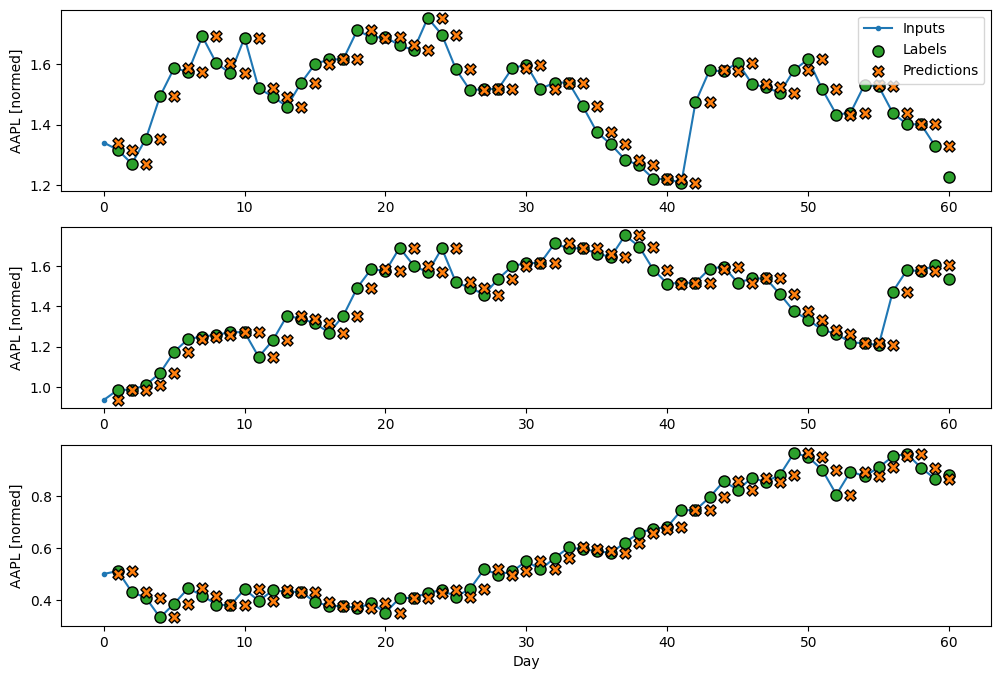

In [110]:
wide_window.plot(baseline)

In [111]:
MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [112]:
conv_window = WindowGenerator(
    input_width=60,
    label_width=1,
    shift=1,
    label_columns=['AAPL'])

conv_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['AAPL']

In [113]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [114]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [115]:
history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4496 - mean_absolute_error: 0.4670 - val_loss: 0.0277 - val_mean_absolute_error: 0.1370
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - mean_absolute_error: 0.1515 - val_loss: 0.0219 - val_mean_absolute_error: 0.1204
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mean_absolute_error: 0.1068 - val_loss: 0.0218 - val_mean_absolute_error: 0.1248
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mean_absolute_error: 0.1010 - val_loss: 0.0192 - val_mean_absolute_error: 0.1164
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - mean_absolute_error: 0.0943 - val_loss: 0.0158 - val_mean_absolute_error: 0.1006
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0848 - val_loss: 0.0150 - val_mean_absolute_error: 0.1021
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - mean_absolute_error: 0.0779 - val_loss: 0.01

In [116]:
val_performance

{'Baseline': [0.004312998149544001, 0.047871410846710205],
 'Multi step dense': [0.026201220229268074, 0.14012718200683594]}

In [117]:
performance

{'Baseline': [0.002681300975382328, 0.039202895015478134],
 'Multi step dense': [0.056771229952573776, 0.2152935415506363]}

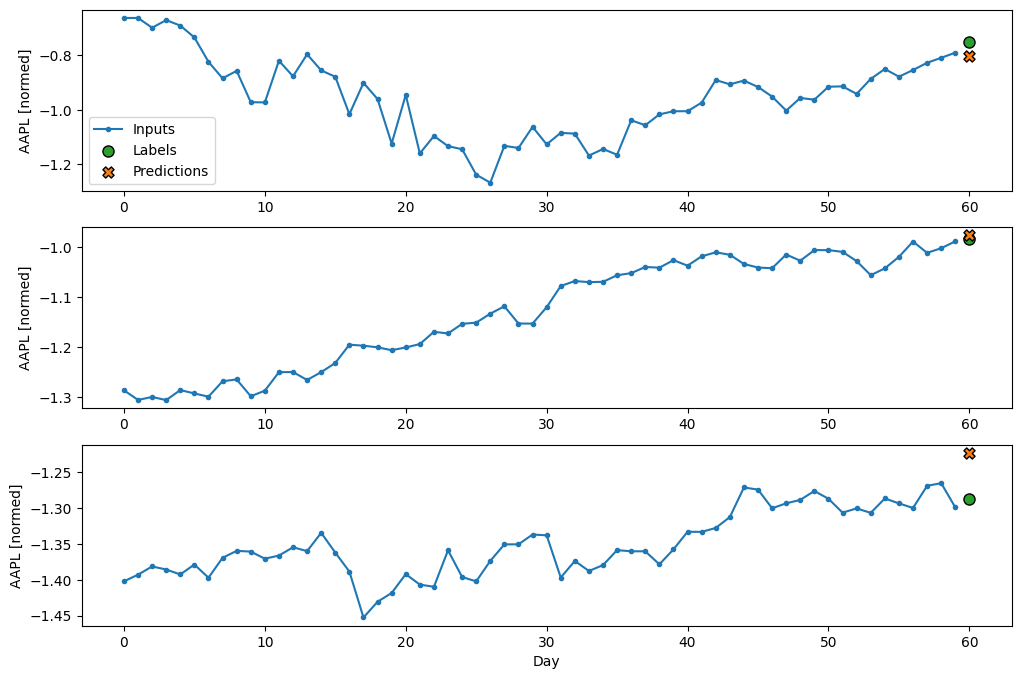

In [118]:
conv_window.plot(multi_step_dense)

In [119]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(60,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [120]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [121]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.2905 - mean_absolute_error: 0.4199 - val_loss: 0.1179 - val_mean_absolute_error: 0.3003
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0483 - mean_absolute_error: 0.1659 - val_loss: 0.0622 - val_mean_absolute_error: 0.2217
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - mean_absolute_error: 0.1340 - val_loss: 0.0408 - val_mean_absolute_error: 0.1784
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - mean_absolute_error: 0.1067 - val_loss: 0.0198 - val_mean_absolute_error: 0.1154
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - mean_absolute_error: 0.0957 - val_loss: 0.0294 - val_mean_absolute_error: 0.1516
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0839 - val_loss: 0.0340 - val_mean_absolute_error: 0.1632
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333 - mean_absolute_error: 0.1614 


In [122]:
performance

{'Baseline': [0.002681300975382328, 0.039202895015478134],
 'Multi step dense': [0.056771229952573776, 0.2152935415506363],
 'Conv': [0.07452339679002762, 0.25485721230506897]}

In [123]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 60, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [124]:
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [125]:
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 60, 1)


In [126]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8786 - mean_absolute_error: 0.8174 - val_loss: 0.1222 - val_mean_absolute_error: 0.2629
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1096 - mean_absolute_error: 0.2369 - val_loss: 0.0877 - val_mean_absolute_error: 0.2092
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0727 - mean_absolute_error: 0.1739 - val_loss: 0.0679 - val_mean_absolute_error: 0.1704
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0574 - mean_absolute_error: 0.1464 - val_loss: 0.0595 - val_mean_absolute_error: 0.1567
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0503 - mean_absolute_error: 0.1308 - val_loss: 0.0527 - val_mean_absolute_error: 0.1451
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0456 - mean_absolute_error: 0.1195 - val_loss: 0.0478 - val_mean_absolute_error: 0.1357
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0412 - mean_absolute_error: 0.1118 - val_loss: 0.04

In [127]:
performance

{'Baseline': [0.002681300975382328, 0.039202895015478134],
 'Multi step dense': [0.056771229952573776, 0.2152935415506363],
 'Conv': [0.07452339679002762, 0.25485721230506897],
 'LSTM': [0.01310797967016697, 0.0626634731888771]}

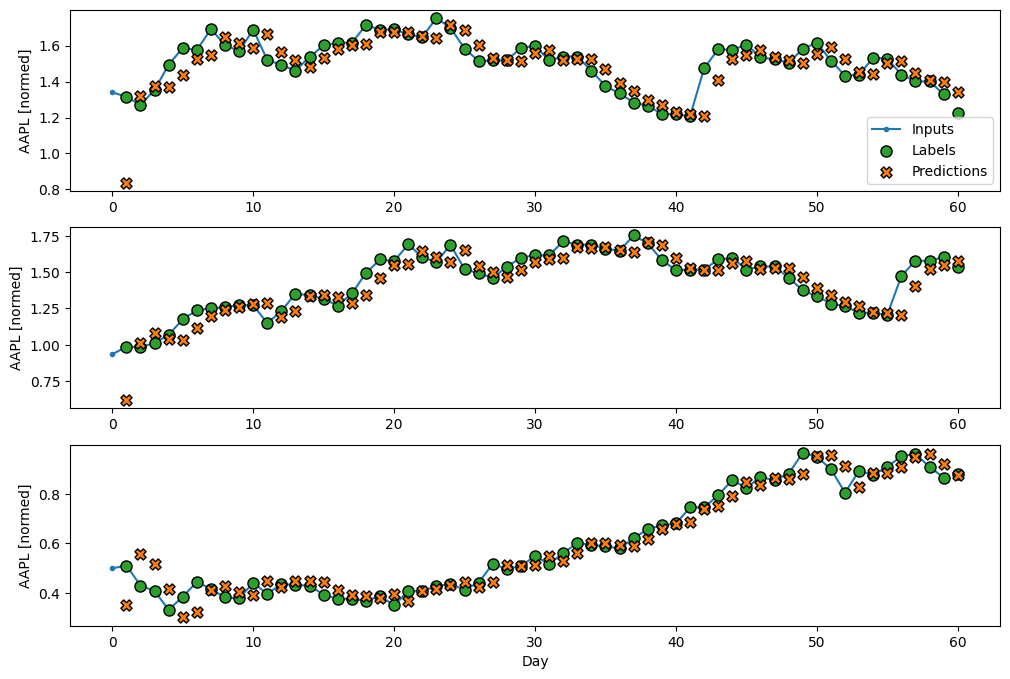

In [128]:
wide_window.plot(lstm_model)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

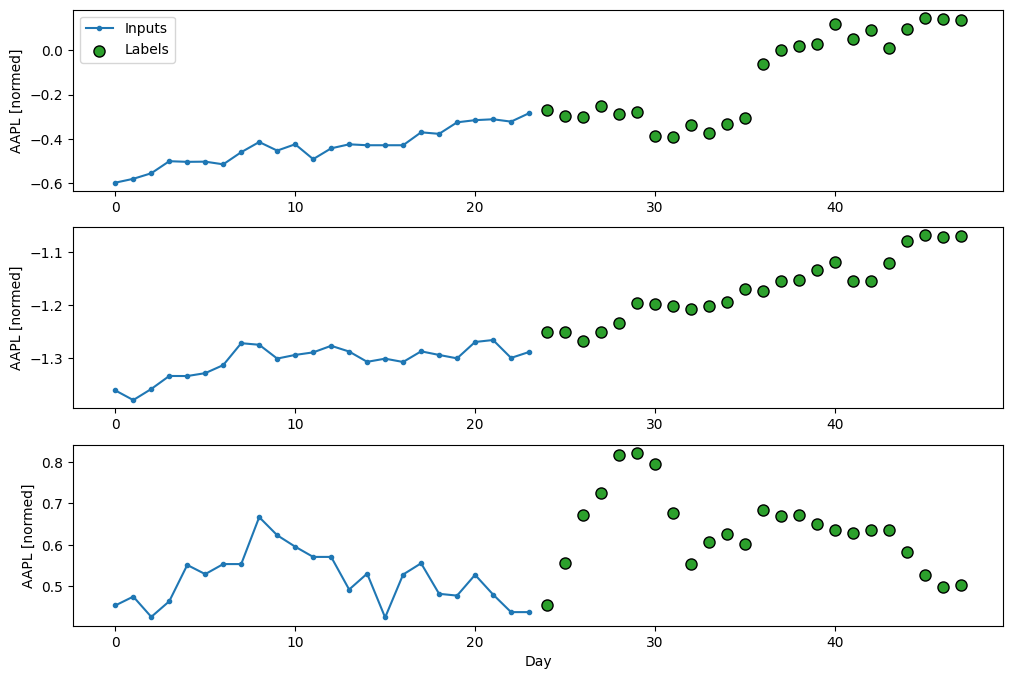

In [150]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0421 - mean_absolute_error: 0.1636


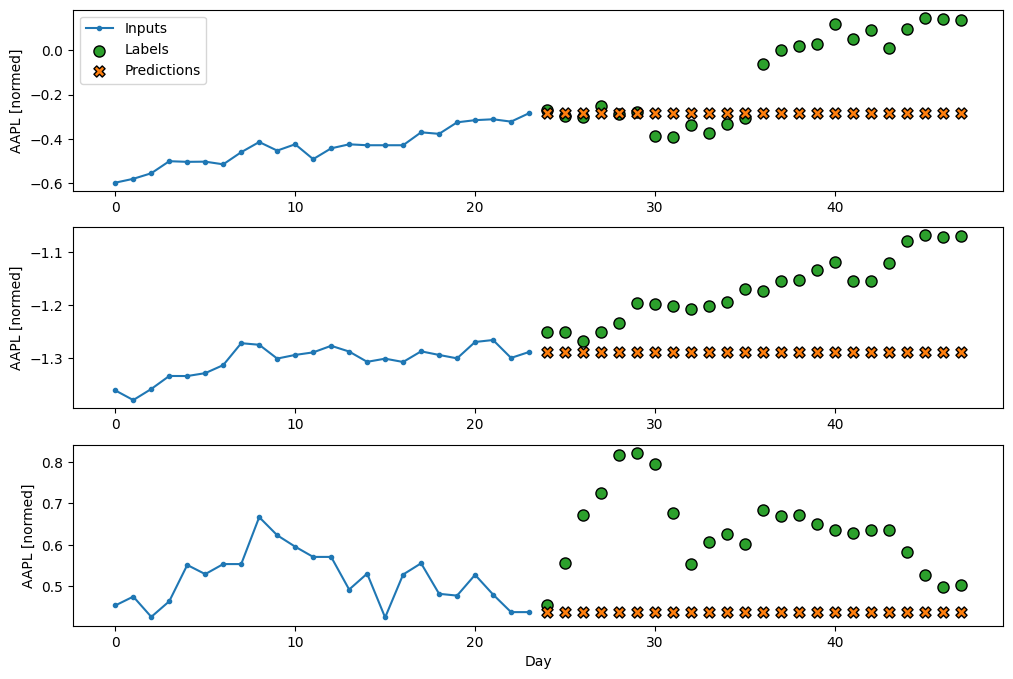

In [151]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8636 - mean_absolute_error: 0.8301 - val_loss: 0.6369 - val_mean_absolute_error: 0.7244
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3388 - mean_absolute_error: 0.4798 - val_loss: 0.1565 - val_mean_absolute_error: 0.3055
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1568 - mean_absolute_error: 0.3249 - val_loss: 0.1532 - val_mean_absolute_error: 0.3124
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0849 - mean_absolute_error: 0.2370 - val_loss: 0.0901 - val_mean_absolute_error: 0.2432
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0490 - mean_absolute_error: 0.1805 - val_loss: 0.0782 - val_mean_absolute_error: 0.2330
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - mean_absolute_error: 0.1608 - val_loss: 0.0712 - val_mean_absolute_error: 0.2251
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0385 - mean_absolute_error: 0.1520 - val_loss: 0.06

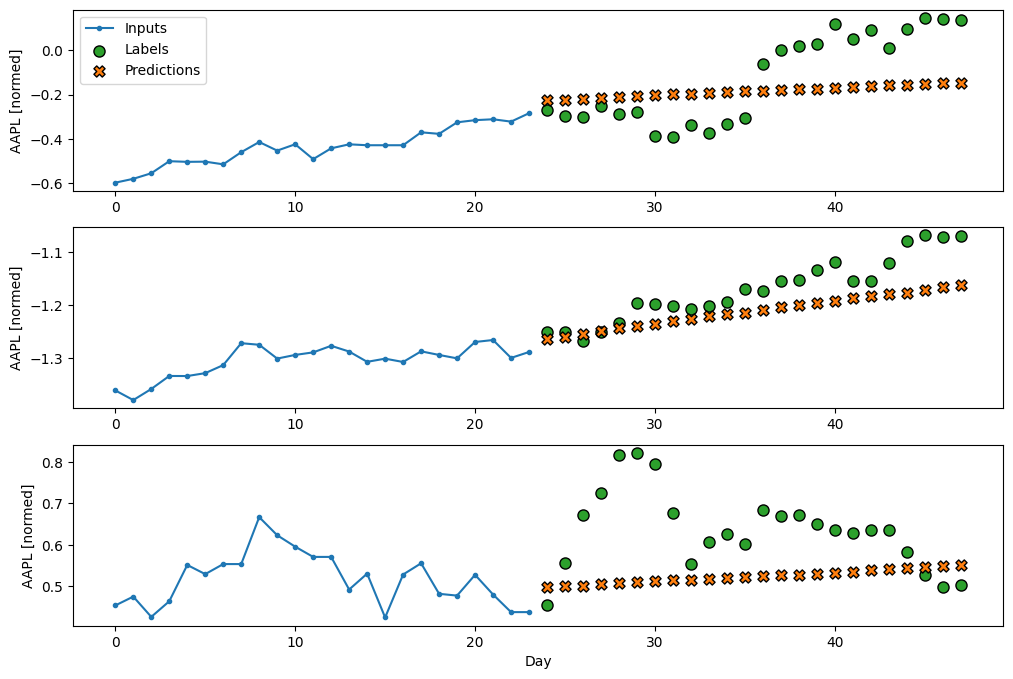

In [152]:
multi_lstm_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, lstm_units].
    # adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [153]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [154]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [155]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [156]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [157]:
def call(self, inputs, training=None):

  # use a TensorArray to capture dynamically unrolled outputs
  predictions = []

  # initialize the LSTM state
  prediction, state = self.warmup(inputs)

  # insert the first prediction
  predictions.append(prediction)

  # run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # use the last prediction as input
    x = prediction

    # execute one lstm step
    x, state = self.lstm_cell(x, states=state,
                              training=training)

    # convert the lstm output to a prediction
    prediction = self.dense(x)

    # add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [158]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 1)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 602ms/step - loss: 0.7443 - mean_absolute_error: 0.7493 - val_loss: 0.1137 - val_mean_absolute_error: 0.2757
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1003 - mean_absolute_error: 0.2434 - val_loss: 0.0809 - val_mean_absolute_error: 0.2329
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0608 - mean_absolute_error: 0.1957 - val_loss: 0.0739 - val_mean_absolute_error: 0.2233
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0416 - mean_absolute_error: 0.1581 - val_loss: 0.0642 - val_mean_absolute_error: 0.2103
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0371 - mean_absolute_error: 0.1440 - val_loss: 0.0614 - val_mean_absolute_error: 0.2082
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0349 - mean_absolute_error: 0.1417 - val_loss: 0.0611 - val_mean_absolute_error: 0.1998
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0360 - mean_absolute_error: 0.1431 - val_loss:

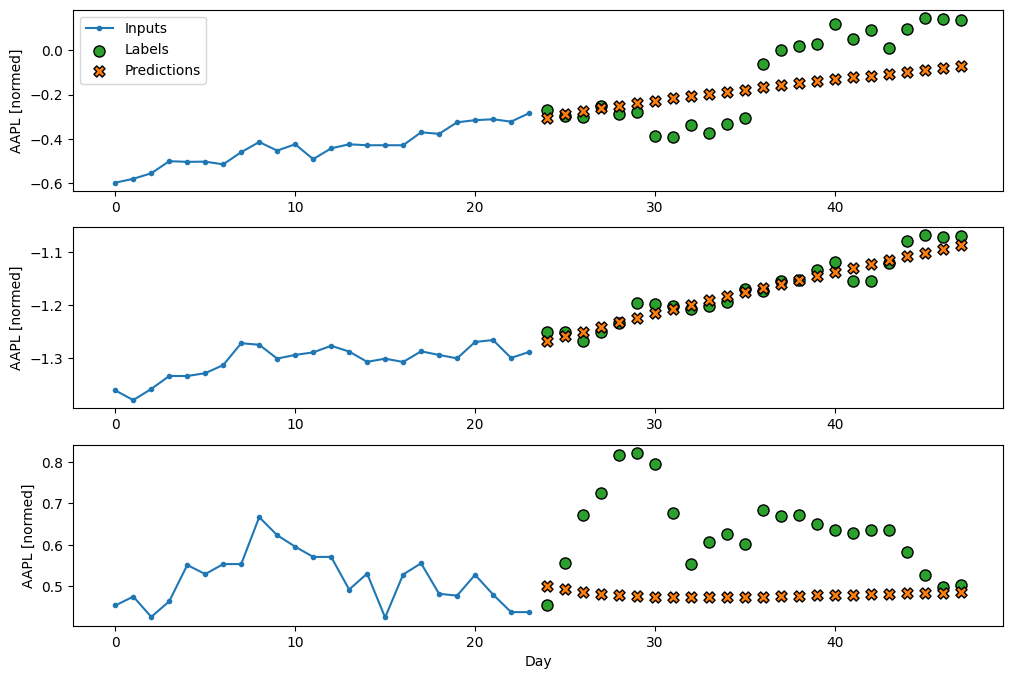

In [159]:
history = compile_and_fit(feedback_model, multi_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Deep Sequence Model Using LSTM

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
fname = os.path.join("drive", "MyDrive", "DataSets", "jena_climate","jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [6]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

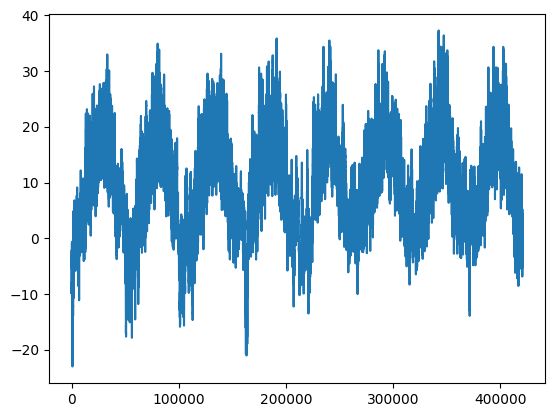

In [7]:
plt.plot(range(len(temperature)), temperature)
plt.show()

In [8]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

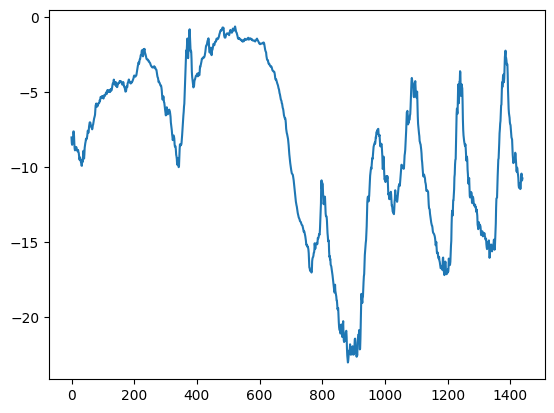

In [9]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [17]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 12, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 6, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - loss: 34.6888 - mae: 4.4234 - val_loss: 16.4021 - val_mae: 3.1657
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 15.1913 - mae: 3.0978 - val_loss: 14.0769 - val_mae: 2.9498
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - loss: 13.6102 - mae: 2.9309 - val_loss: 14.1359 - val_mae: 2.9419
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 12.6821 - mae: 2.8242 - val_loss: 14.6408 - val_mae: 3.0325
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 43ms/step - loss: 12.0808 - mae: 2.7553 - val_loss: 15.8206 - val_mae: 3.1279
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 11.5316 - mae: 2.6927 - val_loss: 13.8944 - val_mae: 2.9394
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - loss: 11.1573 - mae: 2.6475 - val_loss: 13.9548 - val_mae: 2.9377
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - loss: 10.8213 - mae: 2.6055 - val_loss: 14.3291 - val_mae: 2.9924
Epoch 9/10
819/819 ━━━━━

In [18]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - loss: 78.0156 - mae: 6.7464 - val_loss: 13.0559 - val_mae: 2.7507
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 12.0020 - mae: 2.6737 - val_loss: 9.6437 - val_mae: 2.4161
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - loss: 9.9933 - mae: 2.4732 - val_loss: 9.4156 - val_mae: 2.3734
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 9.5340 - mae: 2.4138 - val_loss: 9.7306 - val_mae: 2.4046
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 9.2047 - mae: 2.3696 - val_loss: 9.5608 - val_mae: 2.3821
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - loss: 8.9695 - mae: 2.3355 - val_loss: 9.9214 - val_mae: 2.4208
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 8.7514 - mae: 2.3039 - val_loss: 9.6050 - val_mae: 2.3828
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 8.5807 - mae: 2.2794 - val_loss: 9.5590 - val_mae: 2.3794
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

In [20]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 195s 229ms/step - loss: 48.4032 - mae: 5.2054 - val_loss: 9.5440 - val_mae: 2.4129
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - loss: 15.3857 - mae: 3.0441 - val_loss: 9.2499 - val_mae: 2.3787
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 189s 230ms/step - loss: 14.6131 - mae: 2.9643 - val_loss: 9.1473 - val_mae: 2.3591
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 200s 228ms/step - loss: 14.1104 - mae: 2.9133 - val_loss: 9.0409 - val_mae: 2.3353
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 228ms/step - loss: 13.5942 - mae: 2.8580 - val_loss: 8.9013 - val_mae: 2.3132
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 227ms/step - loss: 13.2841 - mae: 2.8306 - val_loss: 8.9942 - val_mae: 2.3210
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 203s 228ms/step - loss: 12.9419 - mae: 2.7916 - val_loss: 8.7737 - val_mae: 2.2907
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 186s 227ms/step - loss: 12.7074 - mae: 2.7659 - val_loss: 9.0676 - val_mae: 2.3340
Epoch 9/10
819/8

In [15]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 264s 316ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 260s 317ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 260s 317ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 262s 318ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 257s 313ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 258s 315ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 259s 311ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 261s 318ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 257s 314ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/1

In [16]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 163ms/step - loss: 54.3798 - mae: 5.4667 - val_loss: 11.1328 - val_mae: 2.5722
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 165ms/step - loss: 9.8994 - mae: 2.4628 - val_loss: 10.1610 - val_mae: 2.4620
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 8.7927 - mae: 2.3065 - val_loss: 10.1321 - val_mae: 2.4468
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 169ms/step - loss: 8.3479 - mae: 2.2454 - val_loss: 10.4513 - val_mae: 2.4857
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 169ms/step - loss: 7.9224 - mae: 2.1878 - val_loss: 10.1579 - val_mae: 2.4572
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 7.5903 - mae: 2.1412 - val_loss: 10.9369 - val_mae: 2.5358
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 7.2999 - mae: 2.0971 - val_loss: 10.6006 - val_mae: 2.4983
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 171ms/step - loss: 7.0515 - mae: 2.0637 - val_loss: 11.1200 - val_mae: 2.5712
Epoch 9/10
819/